In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight

sys.path.append('../bitome-kb/')
from pathlib import Path
from bitome.core import Bitome
from math import log,exp,inf
bitome = Bitome.init_from_file('../bitome-kb/bitome.pkl')
from feature_functions import *

from Bio.SeqFeature import FeatureLocation
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.Seq import Seq

In [2]:
import ast
im_info = pd.read_csv('data/precise2_im_info_new.csv')
IM_genes = {}
for i in range(len(im_info['im_name'])):
    IM_genes[im_info['im_name'][i]] = ast.literal_eval( im_info['genes'][i] )
IM_genes.keys()

dict_keys(['CysB-1', 'HprR+CusR', 'PhoB-1', 'Fnr-1', 'TdcAR', 'Fimbriae', 'PurR-2', 'Fnr+NarL', 'GalRS', 'BtsR', 'PyrR', 'PlaR', 'RpoN+FhlA', 'RhaS', 'NanR', 'FadR', 'NrdR', 'GlcC', 'BaeR+CpxR', 'NikR', 'Isoleucine', 'RpoN+PspF', 'OxyR', 'TrpR', 'CsqR', 'LldR', 'Thiamine-1', 'PuuR', 'YcjW', 'PdhR+OmpR', 'NsrR', 'GntR', 'Fnr+NarLP', 'RcsAB', 'MalT', 'TyrR', 'Molybdopterin', 'Fnr-2', 'AtoC', 'Leucine', 'SoxS', 'Translation', 'RcnR', 'Lrp', 'Nac', 'KdpE', 'PhoB-2', 'RbsR', 'CysB-2', 'FlhDC-1', 'GatR', 'ArgR', 'GadX', 'RpoN+NtrC-1', 'XylR', 'ArcA', 'BirA', 'EvgA', 'BluR', 'LsrR', 'Zur', 'RpoE', 'Fur-1', 'PurR-1', 'ArgP', 'AllR', 'FucR', 'Fur-2', 'Mlc', 'CecR', 'Fnr+IHF+gcvB', 'YgbI', 'LexA', 'Cra', 'GlpR', 'RpoN+NtrC-2', 'PaaX', 'Oligopeptide', 'CdaR', 'RpoN+PrpR+Cra', 'FliA', 'CpxR', 'Histidine', 'RpoH', 'GadE+FliZ', 'GcvA', 'YdeO+H-NS', 'NagC', 'GutM+SrlR', 'MetJ', 'RpoS', 'CysB-3', 'FlhDC-2', 'RutR', 'PhoP', 'RyhB', 'BasR', 'NarL', 'RpoS+ArgR+RpoN', 'Crp-related-2'])

In [3]:
features = pd.read_csv('features_avg.csv')
S = pd.read_csv('data/S.csv')
X = features.iloc[:,1:].values
X = StandardScaler().fit_transform(X)
ID = list(features['ID'])

In [4]:
target_labels={}
for r in IM_genes.keys():
    target_labels[r] = []
    for i in range( len(ID) ):
        if ID[i] in IM_genes[r]:
            target_labels[r].append( 1 )
        else:
            target_labels[r].append( 0 )          

In [5]:
pwm_db = rpwm('data/motif_pwm_db.txt')
pwm_im = rlogodds('data/motif_logodds.txt')
IM_motif_to_use = list( set(pwm_im.keys())&set(IM_genes.keys()) )

tf_list =['AraC', 'ArcA', 'ArgP', 'ArgR', 'BaeR', 'BasR', 'CysB', 'CpxR', 
          'Cra', 'CRP', 'Mlc', 'MqsA', 'EvgA', 'ExuR', 'FadR', 'IclR', 'IscR', 
          'IHF', 'FhlA', 'FlhDC', 'FNR', 'Fur', 'GadE', 'GadW', 'GadX', 'GalR', 'GalS', 
          'GcvA', 'GlpR', 'GlrR', 'GntR', 'TyrR', 'LexA', 'LeuO', 'Lrp', 'MalT', 'MetJ', 'Nac', 
          'NagC', 'NanR', 'NarL', 'NarP', 'NrdR', 'NsrR', 'NtrC', 'OmpR', 'OxyR', 'PdhR', 'PhoB', 'PhoP',
          'PurR', 'PuuR', 'RcsAB', 'RhaS', 'RutR', 'SoxS', 'TrpR', 'XylR', 'YdeO']
regulon_genes={}
for TF in bitome.transcription_factors:
    if TF.name in tf_list:
        regulon_genes[TF.name] = []   
        for r in TF.regulons:
                for p in list(r.regulated_promoters.values())[0]:
                    if p.transcription_unit != None and len(p.transcription_unit.genes)>0:
                        for g in p.transcription_unit.genes:
                            regulon_genes[TF.name].append( g.locus_tag)
# cobvert gene name and b number.
b_g = {}
for g in bitome.genes:
    b_g[ g.locus_tag ] = g.name
#regulon_labels
regulon_labels = {}
for r in regulon_genes.keys():
    regulon_labels[r] = []
    for i in range( len(ID) ):
        if ID[i] in regulon_genes[r]:
            regulon_labels[r].append( 1 )
        else:
            regulon_labels[r].append( 0 )

In [6]:
motif_list = list(regulon_genes.keys())
for im_motif in IM_motif_to_use:
    motif_list.append( im_motif + ' im')

In [7]:
w_shape = {}
X_shape = {}
Xld_shape = {}
for r in motif_list:
    f_name = r
    if f_name == 'FNR':
        f_name = 'Fnr'
    if f_name == 'CRP':
        f_name = 'Crp'
        
    shape_f_list = [f_name +' HelT_avg', f_name +' HelT_range', f_name + ' MGW_avg',f_name + ' MGW_range',
       f_name +' ProT_avg', f_name +' ProT_range',f_name +' Roll_avg',f_name +' Roll_range',
       f_name +' HelT_max',f_name +' HelT_min',f_name +' MGW_max',f_name +' MGW_min',
       f_name +' ProT_max',f_name +' ProT_min',f_name +' Roll_max',f_name +' Roll_min']
    X_shape[f_name] = features[ shape_f_list ].iloc[:,:].values
    if r in regulon_genes.keys():
        w_shape[f_name] = ld( X_shape[f_name], regulon_labels[r] )
    else:
        im_name = r[:-3]
        w_shape[f_name] = ld( X_shape[f_name], target_labels[im_name] )
        
    Xld_temp = []
    for v in X_shape[f_name]:
        Xld_temp.append(  np.matmul( w_shape[f_name] , v) )
    Xld_shape[f_name] = Xld_temp

In [8]:
eng_features = pd.DataFrame(Xld_shape)
eng_features.columns = [ n+'_shape_ld' for n in Xld_shape.keys()]

X_ld_sigma = {}
w_sigma = {'Sigma70': np.array([ 1.65064382e-02, -6.59506008e-02,  3.02672899e-01, -5.24886433e-02,
        1.71139291e-02, -5.81206469e-02,  1.50473443e-01, -6.07490918e-04,
       -6.33659058e-01,  1.83387202e-01]), 'Sigma38': np.array([-0.01371682, -0.20837012, -0.01447272, -0.08668739, -0.01633375,
        0.06734916, -0.07138144,  0.00261692, -0.543808  ,  0.58861234]), 'Sigma32': np.array([ 0.04611459, -0.27112878,  0.78284334, -0.03343359,  0.03332323,
       -0.13342375,  0.0499618 ,  0.01279136,  0.89601573, -1.3806742 ]), 'Sigma24': np.array([ 0.00797833, -0.11419877,  0.09339727, -0.06414143,  0.03343402,
       -0.16363185,  0.25952174, -0.02545569, -0.45804491,  0.98356359]), 'Sigma28': np.array([-0.03337679, -0.44776207,  0.83001936, -0.14254413,  0.0937775 ,
        0.02082157,  0.9029926 , -0.12715429, -5.67666246,  2.79836743]), 'Sigma54': np.array([ 0.00849921, -0.29833907,  0.19381744, -0.14867898, -0.1209861 ,
       -0.55674056,  0.08177916,  0.1294853 ,  2.10054191, -1.99187276])}

for signame in w_sigma.keys():
    temp = features[[signame + '_Prib_Start', signame + '_Prib_score',
       signame + '_Prib_hmd', signame + '_Prib_Tm', signame + '_m35_Start',
       signame + '_m35_score', signame +'_m35_hmd', signame +'_Spacer_Length',
       signame +'_Spacer_AT_ratio', signame + '_hepta_ratio']].iloc[:,:].values
    
    Xld_temp = []
    for v in temp:
        Xld_temp.append(  np.matmul( w_sigma[ signame ] , v) )
    X_ld_sigma[ signame ] = Xld_temp
    eng_features[signame + '_LD'] = Xld_temp
    
for r in motif_list:
    f_name = r
    if f_name == 'FNR':
        f_name = 'Fnr'
    if f_name == 'CRP':
        f_name = 'Crp'
        
    eng_features[f_name+' score'] = features[f_name+' score']

In [9]:
X_eng = eng_features.iloc[:,:].values
X_eng = StandardScaler().fit_transform(X_eng)

In [10]:
table1= pd.read_csv( 'data/hyperopt_LR_engfeature1.csv' , index_col=0)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


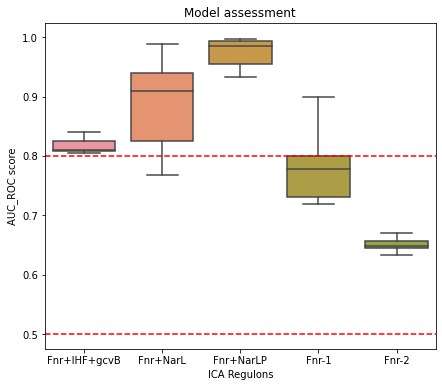

In [11]:
plt.figure( figsize=(7,6))
#sns.swarmplot(x='im', y='mean_train_score', data=hyperopt_result_df)
sns.boxplot(x='im', y='mean_test_score', data=table1)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.ylabel('AUC_ROC score')
plt.xlabel('ICA Regulons')
plt.title('Model assessment')
plt.xlim([-0.5,4.5])
plt.savefig('../../thesis_plots/Fnr_ML_aucroc.svg',dpi=150)

In [17]:
import shap
from sklearn.model_selection import train_test_split
from ast import literal_eval
f_eng_list = list(eng_features.columns)
fnr_ims = ['Fnr+IHF+gcvB', 'Fnr+NarL', 'Fnr+NarLP', 'Fnr-1', 'Fnr-2']

In [18]:
shap_vals= {}
X_fi = pd.DataFrame( X_eng, columns= eng_features.columns , index=eng_features.index)
for im in fnr_ims:
    sub_table = table1[ table1['im']==im]
    sub_table = sub_table[sub_table['param_penalty'] == 'l1']
    sub_table = sub_table.sort_values(by='mean_test_score', ascending=False)
    params = literal_eval(list(sub_table['params'])[0])
    clf = LogisticRegression(solver='saga',class_weight='balanced',verbose=1,max_iter=1000)
    clf.set_params( penalty = params['penalty'])
    clf.set_params( C = params['C'])
    y = pd.Series( target_labels[im] )
    X_train, X_test, y_train, y_test = train_test_split( X_fi, y, test_size=0.3, random_state=7)
    clf.fit(X_train, y_train)
    explainer = shap.Explainer(clf, X_train )
    shap_vals[im] = explainer(X_test) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds


The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 6 seconds


The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds


The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds


The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds


The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished


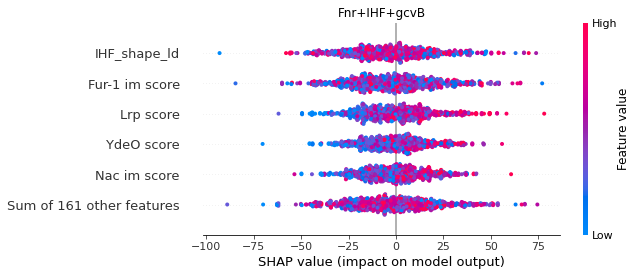

In [45]:
im_name = 'Fnr+IHF+gcvB'
plt.title(im_name)
shap.plots.beeswarm(shap_vals[im_name],max_display=6,show=False)
plt.savefig('../../thesis_plots/'+im_name+'_features.svg',dpi=150)

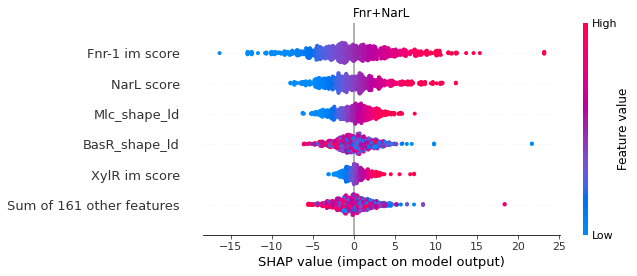

In [46]:
im_name = 'Fnr+NarL'
plt.title(im_name)
shap.plots.beeswarm(shap_vals[im_name],max_display=6,show=False)
plt.savefig('../../thesis_plots/'+im_name+'_features.svg',dpi=150)

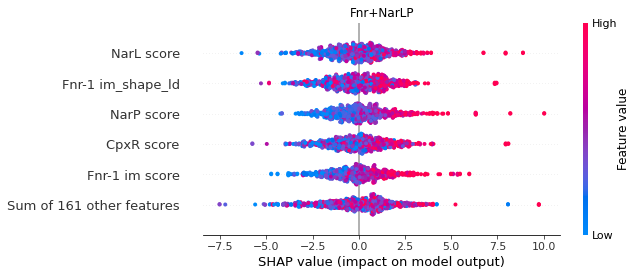

In [52]:
im_name = 'Fnr+NarLP'
plt.title(im_name)
shap.plots.beeswarm(shap_vals[im_name],max_display=6,show=False)
plt.savefig('../../thesis_plots/'+im_name+'_features.svg',dpi=150)

In [12]:
from matplotlib_venn import venn2,venn3
from venn import venn

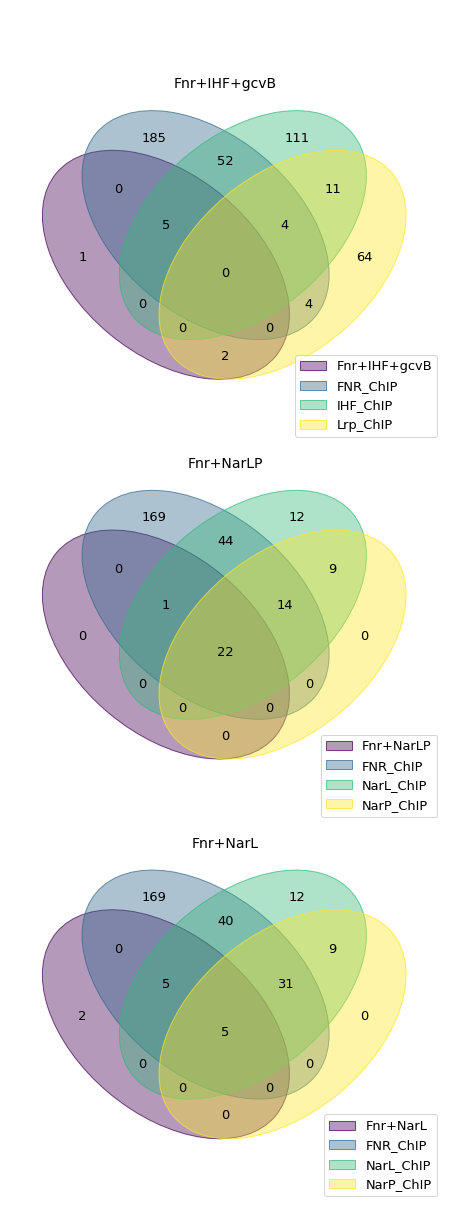

In [16]:
fig,axs=plt.subplots(3,1,figsize=(8,22))

set_0={ 'Fnr+IHF+gcvB':set(IM_genes['Fnr+IHF+gcvB']), 'FNR_ChIP': set(regulon_genes['FNR']),
        'IHF_ChIP':set(regulon_genes['IHF']),
        'Lrp_ChIP':set(regulon_genes['Lrp'])}

venn(set_0,legend_loc='lower right',ax=axs[0])

set_1 = { 'Fnr+NarLP':set(IM_genes['Fnr+NarLP']), 'FNR_ChIP': set(regulon_genes['FNR']),
        'NarL_ChIP':set(regulon_genes['NarL']),
        'NarP_ChIP':set(regulon_genes['NarP'])}
    
venn(set_1,legend_loc='lower right',ax=axs[1])

set_2 = { 'Fnr+NarL':set(IM_genes['Fnr+NarL']), 'FNR_ChIP': set(regulon_genes['FNR']),
        'NarL_ChIP':set(regulon_genes['NarL']),
        'NarP_ChIP':set(regulon_genes['NarP'])}

venn(set_2,legend_loc="lower right",ax=axs[2])

axs[0].set_title('Fnr+IHF+gcvB',y=0.8,fontsize=14)
axs[1].set_title('Fnr+NarLP',y = 0.8,fontsize=14)
axs[2].set_title('Fnr+NarL',y=0.8,fontsize=14)
plt.subplots_adjust(hspace= -0.13)
fig.savefig('../../thesis_plots/Fnr+NarLP_venn.svg',dpi=150)

In [18]:
fnr_all = set( set(IM_genes['Fnr+IHF+gcvB'])|set(IM_genes['Fnr+NarL'])|set(IM_genes['Fnr+NarLP']) \
    |set(IM_genes['Fnr-1'])|set(IM_genes['Fnr-2']) )

(0.0, 1.0, 0.0, 1.0)

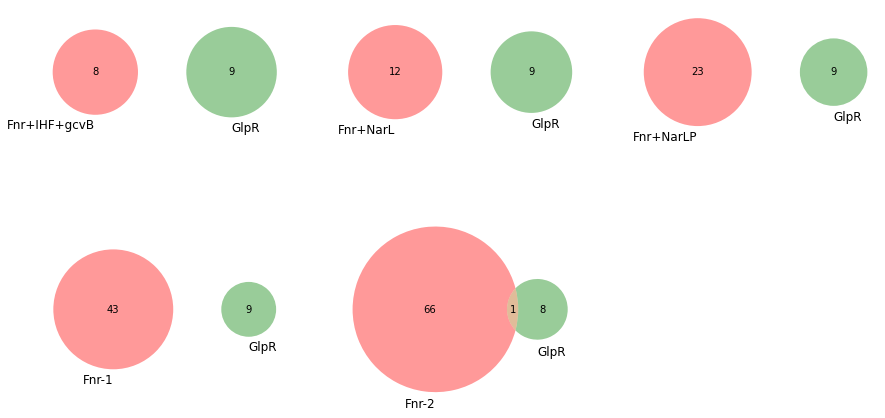

In [40]:
fig,axs=plt.subplots(2,3,figsize=(15,8))
i=0
for im in fnr_ims:
    x_axis = int(i/3)
    y_axis = int(i%3)
    venn2([set(IM_genes[im]),set(regulon_genes['GlpR'])],set_labels = (im ,'GlpR'),ax=axs[x_axis][y_axis])
    i=i+1
axs[-1][-1].axis('off')
#plt.subplots_adjust(wspace= -0.1,hspace=-0.01)

(0.0, 1.0, 0.0, 1.0)

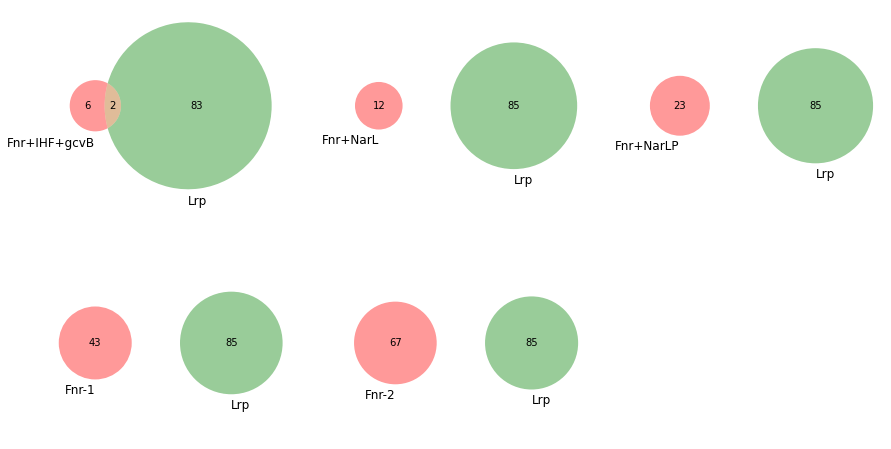

In [41]:
fig,axs=plt.subplots(2,3,figsize=(15,8))
i=0
for im in fnr_ims:
    x_axis = int(i/3)
    y_axis = int(i%3)
    venn2([set(IM_genes[im]),set(regulon_genes['Lrp'])],set_labels = (im ,'Lrp'),ax=axs[x_axis][y_axis])
    i=i+1
axs[-1][-1].axis('off')

(0.0, 1.0, 0.0, 1.0)

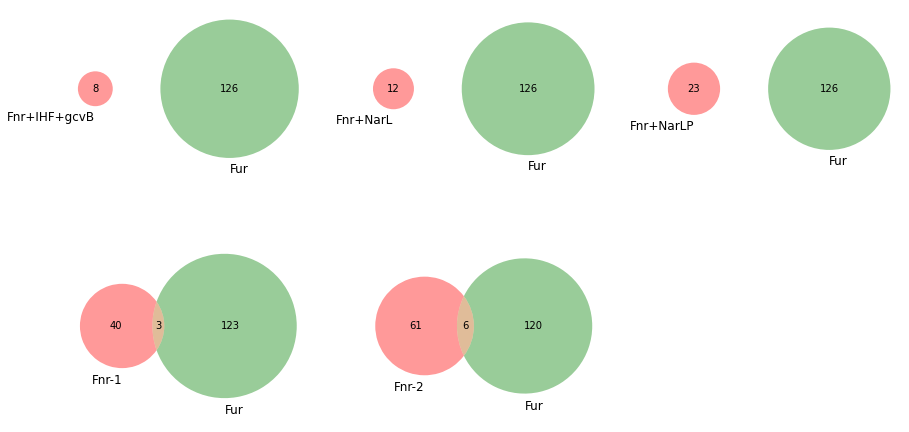

In [54]:
fig,axs=plt.subplots(2,3,figsize=(15,8))
i=0
for im in fnr_ims:
    x_axis = int(i/3)
    y_axis = int(i%3)
    venn2([set(IM_genes[im]),set(regulon_genes['Fur'])],set_labels = (im ,'Fur'),ax=axs[x_axis][y_axis])
    i=i+1
axs[-1][-1].axis('off')

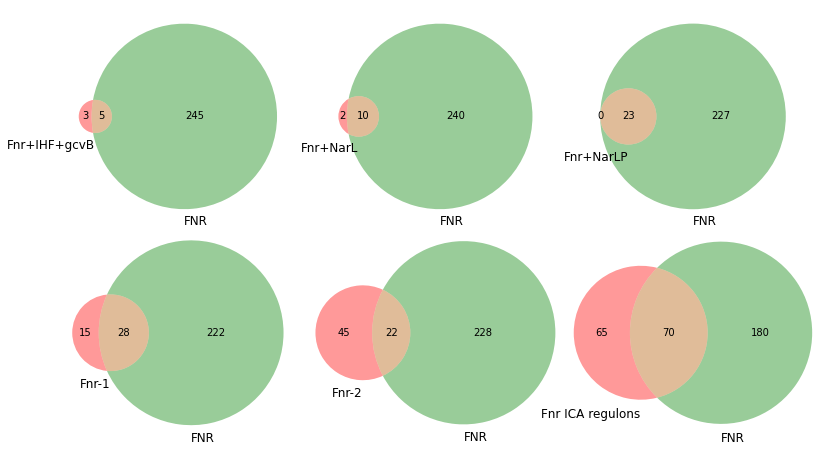

In [26]:
fig,axs=plt.subplots(2,3,figsize=(15,8))
i=0
for im in fnr_ims:
    x_axis = int(i/3)
    y_axis = int(i%3)
    venn2([set(IM_genes[im]),set(regulon_genes['FNR'])],set_labels = (im ,'FNR'),ax=axs[x_axis][y_axis])
    i=i+1
    
venn2([fnr_all,set(regulon_genes['FNR'])],set_labels = ('Fnr ICA regulons','FNR'),ax=axs[1][2])

plt.subplots_adjust(wspace= -0.2,hspace=-0.01)
fig.savefig('../../thesis_plots/FnrIMs_venn.svg',dpi=150)

<AxesSubplot:>

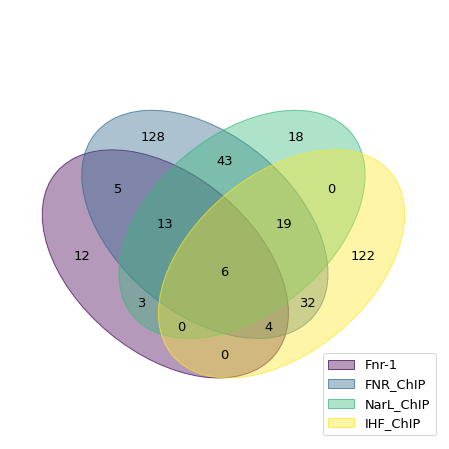

In [15]:
set_a={ 'Fnr-1':set(IM_genes['Fnr-1']), 'FNR_ChIP': set(regulon_genes['FNR']),
        'NarL_ChIP':set(regulon_genes['NarL']),
        'IHF_ChIP':set(regulon_genes['IHF'])}

venn(set_a,legend_loc='lower right')

<AxesSubplot:>

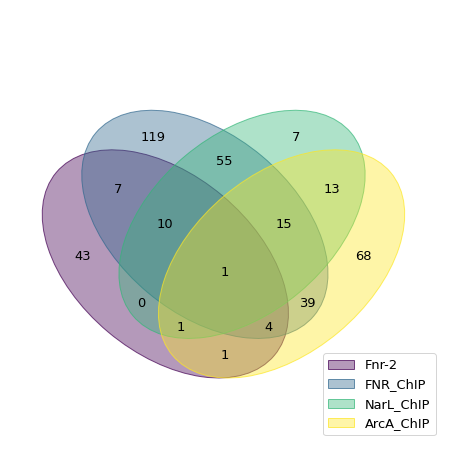

In [16]:
set_b={ 'Fnr-2':set(IM_genes['Fnr-2']), 'FNR_ChIP': set(regulon_genes['FNR']),
        'NarL_ChIP':set(regulon_genes['NarL']),
        'ArcA_ChIP':set(regulon_genes['ArcA'])}

venn(set_b,legend_loc='lower right')

In [11]:
fnr_ims = ['Fnr+IHF+gcvB', 'Fnr+NarL', 'Fnr+NarLP', 'Fnr-1', 'Fnr-2']
fnr_ihf=[]
fnr_ihf_shape = []
fnr1score = []
fnr2score = []
fnrscore = []
fnr_shape = []
fnr_narl = []
fnr_narp = []
fnr_narl_shape = []
fnr_narp_shape = []
fnr_category = []
for k in fnr_ims:
    for i in range(len(ID)):
        if ID[i] in IM_genes[k]:
            fnr_category.append(k)
            fnr_ihf.append( eng_features['IHF score'][i] )
            fnr_ihf_shape.append( eng_features['IHF_shape_ld'][i] )
            fnr1score.append(  eng_features['Fnr-1 im score'][i]  )
            fnr2score.append(  eng_features['Fnr-2 im score'][i]  )
            fnrscore.append(  eng_features['Fnr score'][i]  )
            fnr_shape.append(  eng_features['Fnr_shape_ld'][i]  )
            fnr_narl.append( eng_features['NarL score'][i] )
            fnr_narp.append( eng_features['NarP score'][i] )
            fnr_narl_shape.append( eng_features['NarL_shape_ld'][i])
            fnr_narp_shape.append( eng_features['NarP_shape_ld'][i])
            
import random
for i in range(200):
    rand_index = random.randint(100,2000)
    fnr_category.append('Random')
    fnr_ihf.append( eng_features['IHF score'][rand_index] )
    fnr_ihf_shape.append( eng_features['IHF_shape_ld'][rand_index] )
    fnr1score.append(  eng_features['Fnr-1 im score'][rand_index]  )
    fnr2score.append(  eng_features['Fnr-2 im score'][rand_index]  )
    fnrscore.append(  eng_features['Fnr score'][rand_index]  )
    fnr_shape.append(  eng_features['Fnr_shape_ld'][rand_index]  )
    fnr_narl.append( eng_features['NarL score'][rand_index] )
    fnr_narp.append( eng_features['NarP score'][rand_index] )
    fnr_narl_shape.append( eng_features['NarL_shape_ld'][rand_index])
    fnr_narp_shape.append( eng_features['NarP_shape_ld'][rand_index])

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


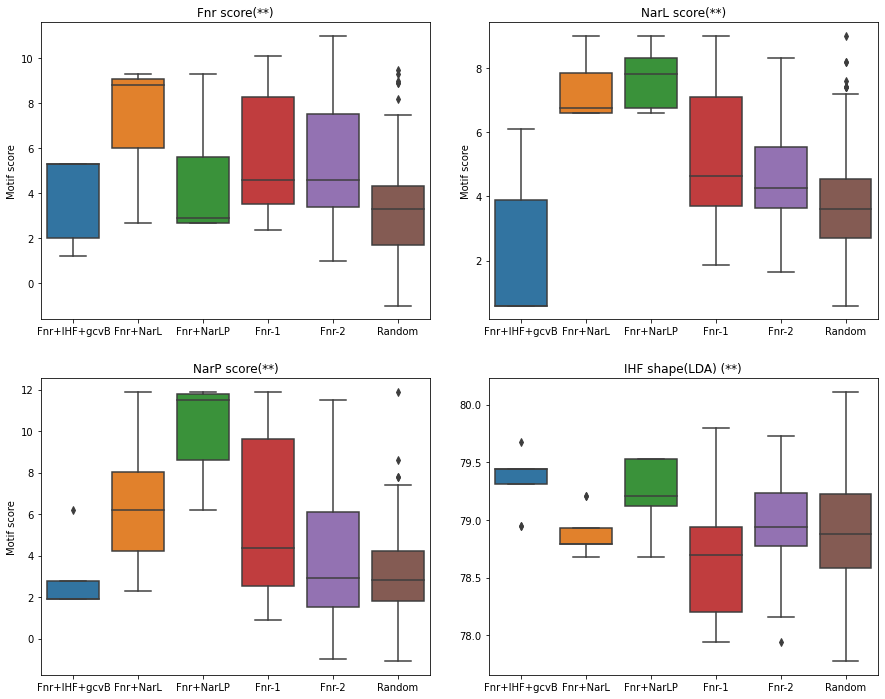

In [22]:
titles = ['Fnr score','NarL score','NarP score','IHF shape(LDA) ']
fnr_features = [fnrscore, fnr_narl,fnr_narp,fnr_ihf_shape]
fig, axs = plt.subplots(2,2,figsize= (15,12))
for i in range(4):
    x_axis = int(i/2)
    y_axis = int(i%2)
    sns.boxplot(fnr_category,fnr_features[i],ax=axs[x_axis][y_axis])
    axs[x_axis][y_axis].set_title(titles[i]+ "(**)")
    axs[x_axis][y_axis].set_ylabel('')
    axs[x_axis][y_axis].set_ylabel('Motif score')
axs[-1][-1].set_ylabel('')
plt.subplots_adjust(wspace= 0.15)
fig.savefig("../../thesis_plots/fnr+narlp_distribution.svg",dpi=150)

## check fnr/narl/narp score distribution for genes in fnr+NarLP and genes not in but also coregulated by 3 TFs

In [23]:
comple_set = ((set(regulon_genes['FNR']) & set(regulon_genes['NarL']) ) &set(regulon_genes['NarP']) ) - set(IM_genes['Fnr+NarLP'])

In [24]:
score_collection = {'Fnr score':[],'NarL score':[],'NarP score':[],'category':[]}
for g in comple_set:
    if g in list(features['ID']):
        temp = features[features['ID']==g]
        score_collection['Fnr score'].append( list(temp['Fnr score'])[0] )
        score_collection['NarL score'].append( list(temp['NarL score'])[0] )
        score_collection['NarP score'].append( list(temp['NarP score'])[0] )
        score_collection['category'].append( 'Other coregulated' )
        
for g in IM_genes['Fnr+NarLP']:
    if g in list(features['ID']):
        temp = features[features['ID']==g]
        score_collection['Fnr score'].append( list(temp['Fnr score'])[0] )
        score_collection['NarL score'].append( list(temp['NarL score'])[0] )
        score_collection['NarP score'].append( list(temp['NarP score'])[0] )
        score_collection['category'].append( 'Fnr+NarLP ICA regulon' )

for i in range(100):
    rand_index = random.randint(100,2000)
    score_collection['Fnr score'].append( list(features['Fnr score'])[rand_index ] )
    score_collection['NarL score'].append( list(features['NarL score'])[rand_index ] )
    score_collection['NarP score'].append( list(features['NarP score'])[rand_index ] )
    score_collection['category'].append( 'Random' )

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


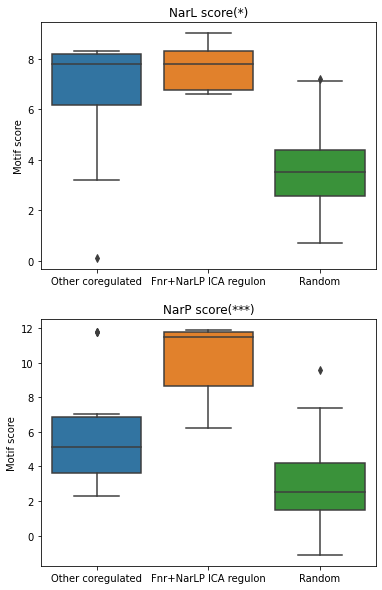

In [27]:
fig, axs = plt.subplots(2,1,figsize= (6,10))
for i in [1,2]:
    sns.boxplot(score_collection['category'], score_collection[list(score_collection.keys())[i]],ax=axs[i-1])
    axs[i-1].set_ylabel('')
axs[0].set_ylabel('Motif score')
axs[1].set_ylabel('Motif score')
axs[0].set_title('NarL score(*)')
axs[1].set_title('NarP score(***)')
plt.subplots_adjust(wspace= 0.1)
fig.savefig('../../thesis_plots/fnr3TF_score_distri.svg',dpi=150)

In [81]:
def categoryToList( x, category ):
    result = {}
    for i in range(len(x)):
        if category[i] not in result.keys():
            result[ category[i] ] = [ x[i] ]
        else:
            result[ category[i] ].append( x[i] )
    return result
from scipy.stats import ttest_ind

In [83]:
result = categoryToList(score_collection['NarP score'],score_collection['category'])
ttest_ind(result['Other coregulated'],result['Fnr+NarLP ICA regulon'])

Ttest_indResult(statistic=-5.276552011498574, pvalue=6.944946453374302e-06)

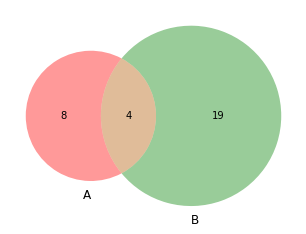

In [91]:
venn2([ set(IM_genes['Fnr+NarL']),set(IM_genes['Fnr+NarLP'])])

In [17]:
def find_tu_byid(tu_id):
    for tu in bitome.transcription_units:
        if tu.id == tu_id:
            return tu


In [22]:
fnr_gene = bitome.get_gene('fnr')

In [24]:
fnr_tu = fnr_gene.transcription_units[0]

In [29]:
fnr_tu.promoter.tf_binding_sites[1].tf_name

'IHF'

(A) Enrichment of Fnr in 5 ICA regulons, the reason of Fnr class regulons's naming
(B) Venn diagrams show that Fnr+IHF+gcvB consist of 5 genes coregulated by Fnr and IHF, 2 genes regulated by Lrp.
And 22/23 genes in Fnr+NarLP are coregulated by Fnr/NarL and NarP TFs,  and high distribution of NarL and NarP scores distinguish them from other 14 genes also coregulated by the 3 TFs.
(C) for Fnr+NarL, it has 5/12 genes coregulated by Fnr and NarL and 5/12 genes coregulated by Fnr, NarL and NarP.
(D) The difference in coregulation types existed in each ICA regulons fractionate 5 ICA regulons all enriched with Fnr.

In [ ]:
possible hierarchy Fnr/IHF/Lrp